In [1]:
# Imports
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando o dataset de treino
df_treino = pd.read_csv('data/dados_treino.csv')

# Carregando o dataset de treino final
df_treino_final = pd.read_csv('data/dados_treino_final.csv')

# Carregando o dataset de validação
df_valid = pd.read_csv('data/dados_valid.csv')

# Carregando o dataset de teste
df_teste = pd.read_csv('data/dados_teste.csv')

In [3]:
# Carregando os nomes das colunas de entrada
with open('data/colunas_entrada.sav', 'rb') as file:
    colunas_entrada = pickle.load(file)

In [4]:
# Prepara a Matriz X
X_treino = df_treino_final[colunas_entrada].values
X_valid = df_valid[colunas_entrada].values
X_teste = df_teste[colunas_entrada].values

In [5]:
# Prepara a Matriz Y
y_treino = df_treino_final['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_teste = df_teste['LABEL_TARGET'].values

In [6]:
print('Shape dos dados de treino:', X_treino.shape, y_treino.shape)
print('Shape dos dados de validação:', X_valid.shape, y_valid.shape)
print('Shape dos dados de teste:', X_teste.shape, y_teste.shape)

Shape dos dados de treino: (3228, 178) (3228,)
Shape dos dados de validação: (1725, 178) (1725,)
Shape dos dados de teste: (1725, 178) (1725,)


## Padronização dos Dados

A padronização é uma técnica de pré-processamento de dados usada em Machine Learning para transformar as variáveis de entrada (features) de modo que tenham média zero e desvio padrão igual a um. Esse processo é realizado subtraindo a média e dividindo pelo desvio padrão de cada variável. A padronização é importante por várias razões:


1. Uniformiza a Escala das Variáveis

Em muitos conjuntos de dados, as variáveis podem operar em escalas muito diferentes. Por exemplo, uma variável pode variar de 0 a 1, enquanto outra pode variar de 0 a 1000. Modelos de Machine Learning que dependem da distância entre os pontos de dados, como K-Means, K-NN (K-Nearest Neighbors), e SVM (Support Vector Machines), podem ser afetados negativamente se as variáveis não estiverem na mesma escala, pois dão mais peso às variáveis com maior magnitude.



2. Acelera a Convergência em Algoritmos de Otimização

Muitos modelos de Machine Learning, especialmente aqueles baseados em métodos de gradiente descendente (como redes neurais e regressão logística), se beneficiam da padronização porque isso facilita a convergência do algoritmo de otimização. Sem padronização, o espaço de busca pode ser distorcido, fazendo com que o algoritmo de otimização leve mais tempo para encontrar o mínimo global.



3. Requisito para Alguns Modelos

Alguns algoritmos de Machine Learning assumem explicitamente que os dados estão centrados em torno de zero e têm variação uniforme. Por exemplo, algoritmos que utilizam regularização, como Ridge e Lasso na regressão linear, podem ter seu desempenho prejudicado se os dados não forem padronizados, pois a regularização penaliza a magnitude dos coeficientes associados a cada variável.



4. Melhora a Interpretabilidade dos Modelos

Quando os dados são padronizados, torna-se mais fácil interpretar a importância das variáveis (features) em alguns modelos, como a regressão linear, onde os coeficientes representam a mudança esperada na variável de saída para uma mudança de uma unidade na variável de entrada, assumindo que todas as outras variáveis permanecem constantes.

In [7]:
# Crio o objeto
scaler = StandardScaler()

# Faço o fit
scaler.fit(X_treino)

# Salva o objeto em disco e carrega para usarmos adiante
scalerfile = 'data/scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

# Carrega o scaler (padronizador)
scaler = pickle.load(open(scalerfile, 'rb'))

# Aplica a padronização em nossas matrizes de dados
X_treino_tf = scaler.transform(X_treino)
X_valid_tf = scaler.transform(X_valid)

## Modelagem Preditiva

### Funções Auxiliares

In [8]:
# Função para calcular a especificidade
def dsa_calcula_especificidade(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

A especificidade é uma métrica usada para avaliar o desempenho de um modelo de classificação, especialmente em problemas de classificação binária. Ela mede a proporção de verdadeiros negativos (TN) em relação ao total de negativos reais, ou seja, a capacidade do modelo de identificar corretamente as instâncias negativas.

Aqui está o que cada parte significa:

**y_pred < thresh**: Esta é uma condição que verifica se a previsão do modelo (y_pred) é menor que um determinado limiar (thresh). Se o modelo for de classificação binária, esse limiar geralmente é 0.5, mas pode ser ajustado de acordo com as necessidades específicas do problema. Essa condição retorna um vetor booleano, onde cada elemento é True se a previsão for menor que o limiar (indicando uma previsão de classe negativa) e False caso contrário.

**y_actual == 0**: Esta é uma condição que verifica quais elementos do vetor de rótulos reais (y_actual) são iguais a 0, ou seja, pertencem à classe negativa. Isso também retorna um vetor booleano.

**(y_pred < thresh) & (y_actual == 0)**: Este é o operador lógico "e" aplicado entre os dois vetores booleanos anteriores. Ele retorna um novo vetor booleano, onde cada elemento é True apenas se ambas as condições forem verdadeiras para esse elemento, ou seja, se a previsão for negativa e o rótulo real também for negativo. Isso representa os verdadeiros negativos (TN).

**sum((y_pred < thresh) & (y_actual == 0))**: Esta é a soma dos valores True no vetor booleano resultante, que é equivalente ao número de verdadeiros negativos (TN).

**sum(y_actual == 0)**: Esta é a soma dos valores True no vetor booleano que representa os rótulos reais negativos, que é equivalente ao número total de instâncias negativas reais (TN + FP).

**sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)**: Esta é a razão entre o número de verdadeiros negativos (TN) e o número total de instâncias negativas reais (TN + FP), que é a definição de especificidade.

In [9]:
# Função para gerar relatório de métricas
def dsa_print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = dsa_calcula_especificidade(y_actual, y_pred, thresh)
    
    print('AUC:%.3f'%auc)
    print('Acurácia:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precisão:%.3f'%precision)
    print('Especificidade:%.3f'%specificity)
    print(' ')
    
    return auc, accuracy, recall, precision, specificity 

In [10]:
thresh = 0.5

### Versão 1 do Modelo - Regressão Logística (Sem Otimização de Hiperparâmetros)

O algoritmo de Regressão Logística é um método estatístico para prever a probabilidade de uma variável dependente binária, com base em uma ou mais variáveis independentes. É amplamente usado para classificação binária, como prever se um e-mail é spam ou não spam, ou se um tumor é maligno ou benigno. A Regressão Logística aplica a função logística (ou sigmoidal) às previsões para transformar valores lineares em probabilidades que variam entre 0 e 1. Aqui está uma descrição passo a passo do algoritmo:


**Modelagem da Probabilidade:** A probabilidade de que a variável dependente seja igual a uma das categorias é modelada como uma função das variáveis independentes. 


**Estimação dos Coeficientes:** Os coeficientes (b) são estimados durante o treinamento do modelo. Isso geralmente é feito usando o método da máxima verossimilhança, que busca encontrar os valores de b que maximizam a probabilidade de observar os dados amostrais. Esse processo pode ser realizado através de técnicas de otimização como o método do gradiente descendente.


**Previsão:** Com os coeficientes estimados, o modelo pode fazer previsões sobre novos dados. A combinação linear dos coeficientes estimados e os valores das variáveis independentes é passada pela função logística para prever a probabilidade de a variável dependente ser 1. Se essa probabilidade for maior que um limiar específico (geralmente 0,5), a previsão é 1; caso contrário, é 0.


**Avaliação do Modelo:** A performance do modelo de Regressão Logística é geralmente avaliada usando métricas como a acurácia, a área sob a curva ROC (AUC-ROC), a precisão, o recall e a pontuação F1. Essas métricas ajudam a entender como o modelo performa tanto em termos de sensibilidade quanto de especificidade.


**Regularização:** Para evitar o overfitting, especialmente quando o número de observações é pequeno ou quando o modelo é muito complexo (com muitas variáveis independentes), técnicas de regularização como L1 (Lasso) e L2 (Ridge) podem ser aplicadas. A regularização penaliza os coeficientes grandes, reduzindo a complexidade do modelo.

A Regressão Logística é eficaz para problemas de classificação binária e pode ser estendida para classificação multiclasse como a Regressão Logística Multinomial.


https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [11]:
# Construção do modelo

# Cria o classificador (objeto)
lr1 = LogisticRegression()

# Treina e cria o modelo
modelo_v1 = lr1.fit(X_treino_tf, y_treino)

# Previsões 
y_train_preds = modelo_v1.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v1.predict_proba(X_valid_tf)[:,1]

print('Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)\n')

print('Treinamento:\n')
lr1_train_auc, lr1_train_accuracy, lr1_train_recall, lr1_train_precision, lr1_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
lr1_valid_auc, lr1_valid_accuracy, lr1_valid_recall, lr1_valid_precision, lr1_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)

Treinamento:

AUC:0.627
Acurácia:0.660
Recall:0.531
Precisão:0.717
Especificidade:0.790
 
Validação:

AUC:0.525
Acurácia:0.696
Recall:0.471
Precisão:0.325
Especificidade:0.752
 


### Versão 2 do Modelo - Regressão Logística (Com Otimização de Hiperparâmetros)

O algoritmo de Regressão Logística é um método estatístico para prever a probabilidade de uma variável dependente binária, com base em uma ou mais variáveis independentes. É amplamente usado para classificação binária, como prever se um e-mail é spam ou não spam, ou se um tumor é maligno ou benigno. A Regressão Logística aplica a função logística (ou sigmoidal) às previsões para transformar valores lineares em probabilidades que variam entre 0 e 1. Aqui está uma descrição passo a passo do algoritmo:

**Modelagem da Probabilidade:** A probabilidade de que a variável dependente seja igual a uma das categorias é modelada como uma função das variáveis independentes. 


**Estimação dos Coeficientes:** Os coeficientes (b) são estimados durante o treinamento do modelo. Isso geralmente é feito usando o método da máxima verossimilhança, que busca encontrar os valores de b que maximizam a probabilidade de observar os dados amostrais. Esse processo pode ser realizado através de técnicas de otimização como o método do gradiente descendente.

**Previsão:** Com os coeficientes estimados, o modelo pode fazer previsões sobre novos dados. A combinação linear dos coeficientes estimados e os valores das variáveis independentes é passada pela função logística para prever a probabilidade de a variável dependente ser 1. Se essa probabilidade for maior que um limiar específico (geralmente 0,5), a previsão é 1; caso contrário, é 0.

**Avaliação do Modelo:** A performance do modelo de Regressão Logística é geralmente avaliada usando métricas como a acurácia, a área sob a curva ROC (AUC-ROC), a precisão, o recall e a pontuação F1. Essas métricas ajudam a entender como o modelo performa tanto em termos de sensibilidade quanto de especificidade.

**Regularização:** Para evitar o overfitting, especialmente quando o número de observações é pequeno ou quando o modelo é muito complexo (com muitas variáveis independentes), técnicas de regularização como L1 (Lasso) e L2 (Ridge) podem ser aplicadas. A regularização penaliza os coeficientes grandes, reduzindo a complexidade do modelo.

A Regressão Logística é eficaz para problemas de classificação binária e pode ser estendida para classificação multiclasse como a Regressão Logística Multinomial.


In [12]:
# Construção do modelo

# Cria o classificador (objeto)
lr2 = LogisticRegression(random_state = 142, solver = 'liblinear')

# Treina e cria o modelo
modelo_v2 = lr2.fit(X_treino_tf, y_treino)

# Previsões 
y_train_preds = modelo_v2.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v2.predict_proba(X_valid_tf)[:,1]

print('Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)\n')

print('Treinamento:\n')
lr2_train_auc, lr2_train_accuracy, lr2_train_recall, lr2_train_precision, lr2_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
lr2_valid_auc, lr2_valid_accuracy, lr2_valid_recall, lr2_valid_precision, lr2_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)

Treinamento:

AUC:0.630
Acurácia:0.663
Recall:0.532
Precisão:0.720
Especificidade:0.794
 
Validação:

AUC:0.525
Acurácia:0.701
Recall:0.460
Precisão:0.328
Especificidade:0.762
 


### Versão 3 do Modelo - Naive Bayes

O algoritmo Naive Bayes é um método de classificação baseado no teorema de Bayes, com a "ingenuidade" de assumir independência entre os preditores. Em outras palavras, presume-se que a presença ou ausência de uma característica particular em uma classe é independente da presença ou ausência de qualquer outra característica. Esse algoritmo é especialmente adequado para grandes volumes de dados e é eficaz em tarefas de classificação de texto, como filtragem de spam e análise de sentimentos.

Funcionamento Básico do Algoritmo Naive Bayes:

**Modelagem da Probabilidade:** O primeiro passo é calcular a probabilidade de cada classe no conjunto de treinamento, conhecida como probabilidade a priori. Em seguida, calcula-se a probabilidade condicional de cada característica dada cada classe.

**Aplicação do Teorema de Bayes:** Quando uma nova instância precisa ser classificada, o algoritmo aplica o teorema de Bayes para calcular a probabilidade posterior de cada classe, dada a instância. O teorema de Bayes é uma forma de calcular a probabilidade de uma hipótese com base no conhecimento prévio e na evidência atual.

**Independência Condicional:** A "ingenuidade" do algoritmo vem da suposição de independência entre as características. Isso significa que a presença de uma característica em uma classe não está relacionada à presença de outra característica. Essa suposição simplifica os cálculos, permitindo que o produto das probabilidades individuais das características seja usado para calcular a probabilidade total.

**Classificação:** Para cada classe, o algoritmo calcula o produto da probabilidade a priori da classe e as probabilidades condicionais de cada característica dada essa classe. A classe com a maior probabilidade posterior (calculada a partir do teorema de Bayes) é escolhida como a classificação para a instância.

Existem diferentes variações do Naive Bayes, dependendo da distribuição dos dados:

* Gaussian Naive Bayes: Usado quando as características são contínuas e assumem uma distribuição normal.
* Multinomial Naive Bayes: Frequentemente usado em classificação de documentos/textos, onde as características são as contagens ou frequências de ocorrência das palavras.
* Bernoulli Naive Bayes: Usado quando as características são variáveis binárias, indicando a presença ou ausência de uma característica.

**Vantagens:**
* Simplicidade e rapidez na previsão de classes.
* Funciona bem com um grande número de características.
* Desempenho comparativamente bom em casos onde a suposição de independência se mantém.
  
**Desvantagens:**
* A suposição de independência entre as características é muitas vezes irrealista, o que pode afetar o desempenho em algumas tarefas.
* Pode ser superado por outros algoritmos quando a relação entre as características é importante para a classificação.

Apesar de suas limitações, o Naive Bayes continua sendo uma escolha popular devido à sua eficiência e facilidade de interpretação.

https://scikit-learn.org/stable/modules/naive_bayes.html

In [13]:
# Construção do modelo

# Cria o classificador (objeto)
nb = GaussianNB()

# Treina e cria o modelo
modelo_v3 = nb.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v3.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v3.predict_proba(X_valid_tf)[:,1]

print('Modelo Naive Bayes:\n')

print('Treinamento:\n')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = dsa_print_report(y_treino, 
                                                                                                              y_train_preds, 
                                                                                                              thresh)

print('Validação:\n')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = dsa_print_report(y_valid, 
                                                                                                              y_valid_preds, 
                                                                                                              thresh)


Modelo Naive Bayes:

Treinamento:

AUC:0.983
Acurácia:0.927
Recall:0.884
Precisão:0.967
Especificidade:0.970
 
Validação:

AUC:0.984
Acurácia:0.955
Recall:0.865
Precisão:0.909
Especificidade:0.978
 


### Versão 4 do Modelo - XGBoost (Xtreme Gradient Boosting Classifier)

O XGBoost (eXtreme Gradient Boosting) é um algoritmo de aprendizado supervisionado que é amplamente utilizado para problemas de regressão e classificação. É uma implementação otimizada do método de boosting de gradiente, projetada para ser altamente eficiente e flexível. O XGBoost ganhou popularidade por sua velocidade e desempenho em competições de Ciência de Dados, como as hospedadas no Kaggle. Como Funciona o XGBoost:

**Modelo de Árvore de Decisão:** O XGBoost constrói modelos sequenciais usando árvores de decisão. Cada nova árvore é criada para corrigir os erros (resíduos) deixados pelas árvores anteriores.

**Boosting de Gradiente:** A ideia central do boosting de gradiente é combinar muitos modelos fracos (geralmente árvores de decisão) para criar um modelo forte. O "gradiente" no nome se refere ao uso do gradiente descendente para minimizar a função de perda ao adicionar novas árvores.

**Otimização Regularizada:** O XGBoost inclui um termo de regularização na função de perda, que ajuda a controlar a complexidade do modelo. Isso reduz o overfitting e melhora a capacidade de generalização do modelo.

**Técnicas de Otimização:** Utiliza várias técnicas de otimização para melhorar a eficiência e o desempenho, como:

**Pruning de árvores (poda):** Para evitar o crescimento desnecessário de árvores, o XGBoost usa uma estratégia de poda baseada na ganância. Se a adição de um novo nó não resulta em melhoria significativa, a expansão é parada.
Tratamento de valores ausentes: O XGBoost pode automaticamente aprender a melhor maneira de lidar com valores ausentes durante o treinamento.
Paralelismo e Escalabilidade: Capaz de utilizar múltiplos núcleos de CPU durante o treinamento e escalar para sistemas distribuídos de computação.
Ajuste de Hiperparâmetros: O desempenho do XGBoost pode ser significativamente afetado pelo ajuste de hiperparâmetros, incluindo a taxa de aprendizado, o número máximo de árvores, a profundidade de cada árvore e os parâmetros de regularização, entre outros.


**Vantagens**
* Alto Desempenho, frequentemente supera outros algoritmos de aprendizado de máquina em tarefas de classificação e regressão.
* Flexibilidade, pode ser usado para problemas de regressão, classificação, ranking e muitos outros tipos de aprendizado de máquina.
* Portabilidade, disponível em várias linguagens de programação e pode ser executado em diversas plataformas.
* Facilidade de Uso, vem com uma variedade de parâmentos ajustáveis que podem ser afinados para obter o melhor desempenho em um determinado problema.

**Desvantagens**
* Complexidade, ajustar todos os seus hiperparâmetos pode ser uma tarefa desafiadora e demorada.
* Overfitting: Apesar da regularização, modelos muito complexos podem ainda assim sofrer de overfitting, especialmente em dados com ruído

https://xgboost.readthedocs.io/en/stable/index.html

In [14]:
# Construção do modelo (Ensemble)

# Cria o classificador
xgbc = XGBClassifier()

# Treina e cria o modelo
modelo_v4 = xgbc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v4.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v4.predict_proba(X_valid_tf)[:,1]

print('Modelo Xtreme Gradient Boosting Classifier:\n')

print('Treinamento:\n')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = dsa_print_report(y_treino, 
                                                                                                                        y_train_preds, 
                                                                                                                        thresh)

print('Validação:\n')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                        y_valid_preds, 
                                                                                                                        thresh)


Modelo Xtreme Gradient Boosting Classifier:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.993
Acurácia:0.967
Recall:0.940
Precisão:0.901
Especificidade:0.974
 


## Versão 5 do Modelo - RandomForest

O algoritmo RandomForest é um método de aprendizado de máquina para classificação, regressão e outras tarefas, que opera construindo um conjunto de árvores de decisão no momento do treinamento e produzindo a classe que é a moda (valor mais frequente) das classes (classificação) ou predição média (regressão) das árvores individuais. RandomForest pertence à categoria dos métodos de ensemble, especificamente aos métodos de bagging, onde múltiplos modelos são treinados para resolver o mesmo problema e, em seguida, a média ou a votação majoritária de seus resultados é usada para obter uma previsão mais precisa. Funcionamento Básico do RandomForest:

**Seleção Aleatória de Amostras:** Para cada árvore individual, uma amostra aleatória de dados é selecionada do conjunto de treinamento. Este processo é conhecido como bootstrap sampling, que permite que algumas observações sejam selecionadas várias vezes para uma mesma árvore, enquanto outras podem ser deixadas de fora.

**Construção de Árvores de Decisão:** Cada árvore é construída de maneira a crescer ao máximo, com um twist: em cada divisão (ou nó), em vez de procurar a melhor característica entre todas as características disponíveis, o algoritmo busca a melhor característica entre um subconjunto aleatório das características. Isso aumenta a diversidade entre as árvores, o que ajuda a melhorar a robustez do modelo.

**Predição:** Para fazer previsões, o RandomForest utiliza todas as árvores individualmente construídas. No caso de problemas de classificação, a previsão final é feita por votação majoritária, ou seja, a classe mais frequente entre todas as árvores é escolhida como a previsão final. Para problemas de regressão, a média das previsões de todas as árvores é calculada para obter a previsão final.

**Vantagens**
* Robustex, como é contruído a partir de múltiplas árvores, é menos propenso a overfitting do que uma única árvore de decisão.
* Flexibilidade, pode ser usado tanto para tarefas de classificação quanto de regressão
* Fácil de usar, requer pouca preparação dos dados, por exemplo, não é necessário escalar as características.
* Importância das caracteristicas, pode forneceder insights sobre quais características são mais importantes para a previsão

**Desvantagens**
* Complexidade e Tempo de Treinamento, como constrói muitas árvores, pode ser computacionalmente intensivo e lento para treinar, especialmente com grandes volumes de dados.
* Interpretabilidade, embora seja mais interpretável do que alguns modelos de aprendizado de máquina, ainda é mais dificil de interpretar do que uma árovere de decisão única devido à sua natureza de ensemble.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [15]:
# Cria o classificador com RandomForest
rfc = RandomForestClassifier()

# Treina e cria o modelo
modelo_v5 = rfc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v5.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v5.predict_proba(X_valid_tf)[:,1]

print('Modelo Random Forest Classifier:\n')

print('Treinamento:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Modelo Random Forest Classifier:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.994
Acurácia:0.957
Recall:0.963
Precisão:0.844
Especificidade:0.954
 


### Seleção de Modelos

In [16]:
# Tabela de resultados
df_results = pd.DataFrame({'classificador':['RL1', 'RL1', 'RL2', 'RL2', 'NB', 'NB', 'XGB', 'XGB', 'RFC', 'RFC'],
                           'data_set':['treino','valid'] * 5,
                           'auc':[lr1_train_auc,
                                  lr1_valid_auc,
                                  lr2_train_auc,
                                  lr2_valid_auc,
                                  nb_train_auc,
                                  nb_valid_auc,
                                  xgbc_train_auc,
                                  xgbc_valid_auc,
                                  rfc_train_auc,
                                  rfc_valid_auc],
                           'accuracy':[lr1_train_accuracy,
                                       lr1_valid_accuracy,
                                       lr2_train_accuracy,
                                       lr2_valid_accuracy,
                                       nb_train_accuracy,
                                       nb_valid_accuracy,
                                       xgbc_train_accuracy,
                                       xgbc_valid_accuracy,
                                       rfc_train_accuracy,
                                       rfc_valid_accuracy],
                           'recall':[lr1_train_recall,
                                     lr1_valid_recall,
                                     lr2_train_recall,
                                     lr2_valid_recall,
                                     nb_train_recall,
                                     nb_valid_recall,
                                     xgbc_train_recall,
                                     xgbc_valid_recall,
                                     rfc_train_recall,
                                     rfc_valid_recall],
                           'precision':[lr1_train_precision,
                                        lr1_valid_precision,
                                        lr2_train_precision,
                                        lr2_valid_precision,
                                        nb_train_precision,
                                        nb_valid_precision,
                                        xgbc_train_precision,
                                        xgbc_valid_precision,
                                        rfc_train_precision,
                                        rfc_valid_precision],
                           'specificity':[lr1_train_specificity,
                                          lr1_valid_specificity,
                                          lr2_train_specificity,
                                          lr2_valid_specificity,
                                          nb_train_specificity,
                                          nb_valid_specificity,
                                          xgbc_train_specificity,
                                          xgbc_valid_specificity,
                                          rfc_train_specificity,
                                          rfc_valid_specificity]})

df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL1,treino,0.627307,0.660471,0.530979,0.716555,0.789963
1,RL1,valid,0.524777,0.695652,0.471264,0.324752,0.752360
2,RL2,treino,0.630225,0.662639,0.531599,0.720403,0.793680
3,RL2,valid,0.524754,0.700870,0.459770,0.327869,0.761801
4,NB,treino,0.982899,0.927200,0.884139,0.967458,0.970260
5,NB,valid,0.984406,0.955362,0.864943,0.909366,0.978214
6,XGB,treino,1.000000,1.000000,1.000000,1.000000,1.000000
7,XGB,valid,0.993439,0.966957,0.939655,0.900826,0.973856
8,RFC,treino,1.000000,1.000000,1.000000,1.000000,1.000000
9,RFC,valid,0.994288,0.956522,0.962644,0.843829,0.954248


In [17]:
# Resultados em validação com ordenação pelo AUC
df_results[df_results['data_set'] == 'valid'].sort_values(by = 'auc', ascending = False)

,classificador,data_set,auc,accuracy,recall,precision,specificity
9,RFC,valid,0.994288,0.956522,0.962644,0.843829,0.954248
7,XGB,valid,0.993439,0.966957,0.939655,0.900826,0.973856
5,NB,valid,0.984406,0.955362,0.864943,0.909366,0.978214
1,RL1,valid,0.524777,0.695652,0.471264,0.324752,0.752360
3,RL2,valid,0.524754,0.700870,0.459770,0.327869,0.761801


A métrica de desempenho escolhida será a pontuação AUC (AUC Score) do conjunto de validação. É a pontuação mais comum usada para comparar modelos de algoritmos diferentes. Acuracia é ideal para quando é comparado modelos do mesmo algoritimo.

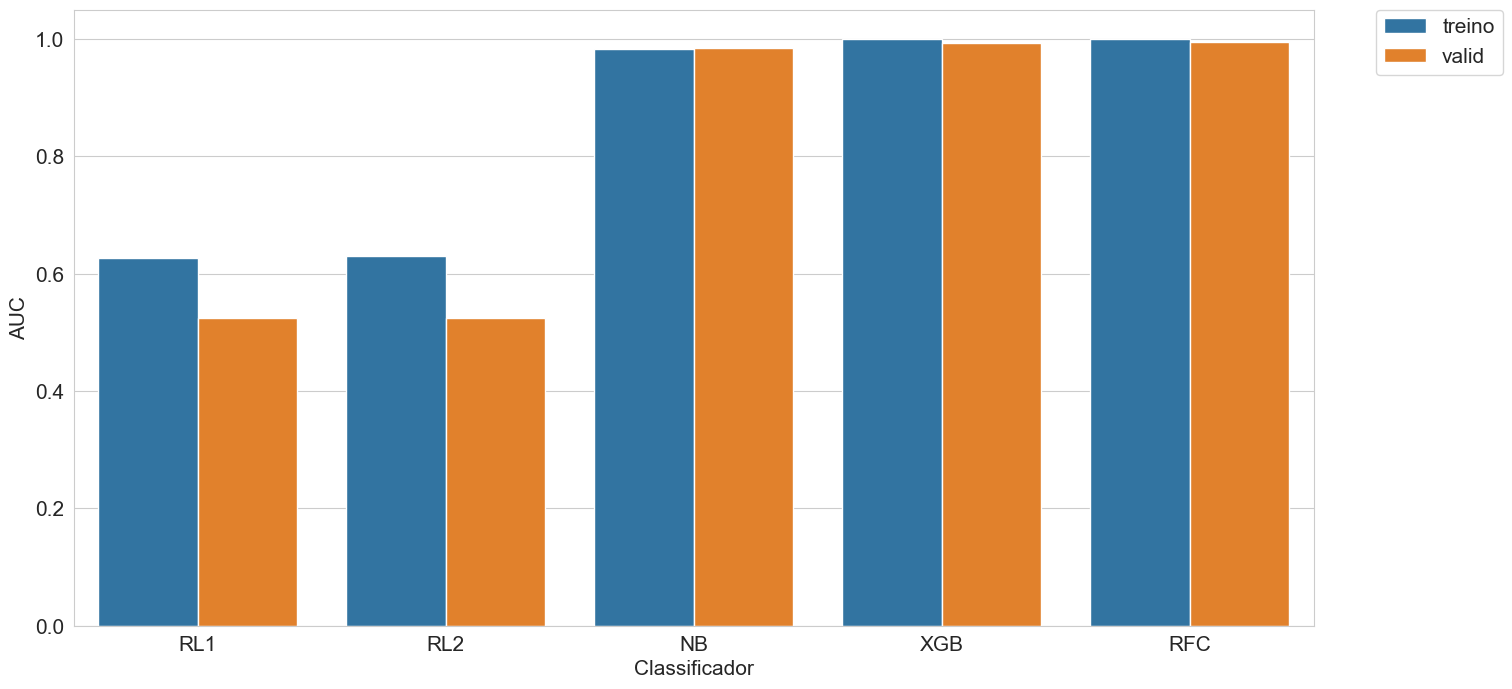

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize = (16, 8))
ax = sns.barplot(x = 'classificador', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classificador', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15);

## Otimização de Hiperparâmetros e Validação Cruzada

A otimização de hiperparâmetros e a validação cruzada são técnicas fundamentais em aprendizado de máquina, usadas para melhorar o desempenho dos modelos e garantir que eles generalizem bem para dados não vistos. Hiperparâmetros são os parâmetros de configuração do modelo que precisam ser definidos antes do treinamento do modelo e que não são aprendidos a partir dos dados. Eles têm um grande impacto no desempenho do modelo. A otimização de hiperparâmetros é o processo de buscar a melhor combinação de hiperparâmetros que resulta no melhor desempenho do modelo para uma tarefa específica. Diferentes métodos podem ser usados para a otimização de hiperparâmetros, incluindo:
* **Grid Search**: Um método exaustivo que testa todas as combinações possíveis de hiperparâmetros dentro de um espaço de busca definido. Método usado neste capítulo.
* **Random Search**: Seleciona aleatoriamente combinações de hiperparâmetros para testar, o que pode ser mais eficiente que o Grid Search em espaços de busca grandes.
* **Otimização Bayesiana**: Utiliza modelos probabilísticos para prever quais combinações de hiperparâmetros podem resultar em melhor desempenho, focando a busca nessas áreas promissoras.
* **Algoritmos Genéticos e Outras Heurísticas**: Abordagens inspiradas na natureza que simulam a evolução para encontrar as melhores combinações de hiperparâmetros.

### Validação Cruzada
A validação cruzada é uma técnica de avaliação de modelos usada para estimar a habilidade de generalização de um modelo em dados não vistos. Isso é importante para evitar o problema de overfitting, onde o modelo se ajusta muito bem aos dados de treinamento mas falha em prever novos dados com precisão. A validação cruzada mais comum é a k-fold:
* O conjunto de dados é dividido aleatoriamente em k subconjuntos (ou "folds").
* O modelo é treinado k vezes, cada vez usando k-1 folds para treinamento e o fold restante para teste.
* O desempenho do modelo é então avaliado usando uma métrica específica, como precisão ou erro quadrático médio, e os resultados são médios para obter uma estimativa geral do desempenho do modelo.
A validação cruzada garante que cada observação dos dados seja usada para treinamento e teste exatamente uma vez, proporcionando uma avaliação robusta do desempenho do modelo. Juntas, a otimização de hiperâmetros e a validação cruzada formam um processo poderoso para desenvolver modelos de aprendizado de máquina. A otimização ajusta o modelo para alcançar o melhor desempenho possível, enquanto a validação cruzada assegura que este desempenho é realista e que o modelo é capaz de generalizar além dos dados de treinamento. Essas técnicas ajudam a maximizar a eficácia dos modelos de aprendizado de máquina em resolver problemas do mundo real.


Para incluir a otimização de hiperparâmetros e a validação cruzada no projeto, você pode usar o GridSearchCV do scikit-learn, que permite buscar a melhor combinação de hiperparâmetros para o modelo. Vamos usar o RandomForest como modelo base.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [19]:
%%time

# Importa a função GridSearchCV
from sklearn.model_selection import GridSearchCV

# Defina o espaço de busca dos hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o classificador com RandomForest
classificador = RandomForestClassifier()

# Configura o GridSearchCV
grid_search = GridSearchCV(estimator = classificador, 
                           param_grid = param_grid, 
                           cv = 5, 
                           scoring = 'roc_auc', 
                           verbose = 2, 
                           n_jobs = -1)

# Treina o modelo com validação cruzada e busca pelos melhores hiperparâmetros
modelo_v5_otimizado = grid_search.fit(X_treino_tf, y_treino)

# Melhores hiperparâmetros encontrados
print('Melhores hiperparâmetros:', modelo_v5_otimizado.best_params_)

# Previsões
y_train_preds = modelo_v5_otimizado.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v5_otimizado.predict_proba(X_valid_tf)[:,1]

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END m

In [20]:
print('Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:\n')

print('Treinamento:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.994
Acurácia:0.959
Recall:0.974
Precisão:0.845
Especificidade:0.955
 


## Qual Versão Final Devemos Usar? Justifique Sua Resposta!

Modelo RandomForest "Vanilla":

Validação:

AUC:0.994
Acurácia:0.957
Recall:0.963
Precisão:0.844
Especificidade:0.954
 

Modelo RandomForest Otimizado:

Validação:

AUC:0.994
Acurácia:0.959
Recall:0.974
Precisão:0.845
Especificidade:0.955

Ambos os modelos com RandomForest apresentam desempenho muito alto, mas há algumas nuances a serem consideradas ao escolher qual deles usar:

**Desempenho na validação**: O modelo com otimização de hiperparâmetros tem uma AUC ligeiramente maior na validação, o que indica que ele pode generalizar um pouco melhor. No entanto, outras métricas são um pouco menores nesse modelo. Essas diferenças são pequenas e podem não ser significativas, dependendo do contexto e da importância relativa dessas métricas para o seu problema específico.

**Complexidade e tempo de treinamento**: A otimização de hiperparâmetros aumenta a complexidade do processo de treinamento e o tempo necessário para treinar o modelo. Se o tempo de treinamento for uma preocupação e as diferenças de desempenho forem consideradas insignificantes, você pode optar pelo modelo sem otimização de hiperparâmetros.

Se você estiver preocupado com o overfitting e quiser um modelo que possa generalizar um pouco melhor para novos dados, o modelo com otimização de hiperparâmetros pode ser a melhor escolha, apesar de seu desempenho ligeiramente inferior na validação em algumas métricas. No entanto, se o tempo de treinamento for uma preocupação e as diferenças de desempenho forem aceitáveis para o seu caso de uso, o modelo sem otimização de hiperparâmetros pode ser suficiente.

Decisão: Usaremos o modelo RandomForest sem otimização de hiperparâmetros pois é mais simples e requer menos tempo de treinamento.

### Salvando o Melhor Modelo

In [21]:
# Grava o modelo em disco
pickle.dump(modelo_v5, open('models/melhor_modelo.pkl', 'wb'), protocol = 4)

> Vamos fazer a avaliação final do melhor modelo.

In [22]:
# Carrega o modelo, as colunas e o scaler
best_model = pickle.load(open('models/melhor_modelo.pkl','rb'))
cols_input = pickle.load(open('data/colunas_entrada.sav','rb'))
scaler = pickle.load(open('data/scaler.sav', 'rb'))

# Carrega os dados
df_train = pd.read_csv('data/dados_treino_final.csv')
df_valid = pd.read_csv('data/dados_valid.csv')
df_test = pd.read_csv('data/dados_teste.csv')

# Cria matrizes x e y

# X
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

# Y
y_train = df_train['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_test = df_test['LABEL_TARGET'].values

# Aplica a transformação nos dados
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

In [23]:
# Previsões de probabilidade
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

> Avaliação final.

In [24]:
thresh = 0.5

print('\nTreinamento:\n')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = dsa_print_report(y_train,
                                                                                               y_train_preds, 
                                                                                               thresh)

print('\nValidação:\n')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = dsa_print_report(y_valid,
                                                                                               y_valid_preds, 
                                                                                               thresh)

print('\nTeste:\n')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = dsa_print_report(y_test,
                                                                                          y_test_preds, 
                                                                                          thresh)


Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 

Validação:

AUC:0.994
Acurácia:0.957
Recall:0.963
Precisão:0.844
Especificidade:0.954
 

Teste:

AUC:0.994
Acurácia:0.955
Recall:0.982
Precisão:0.824
Especificidade:0.947
 


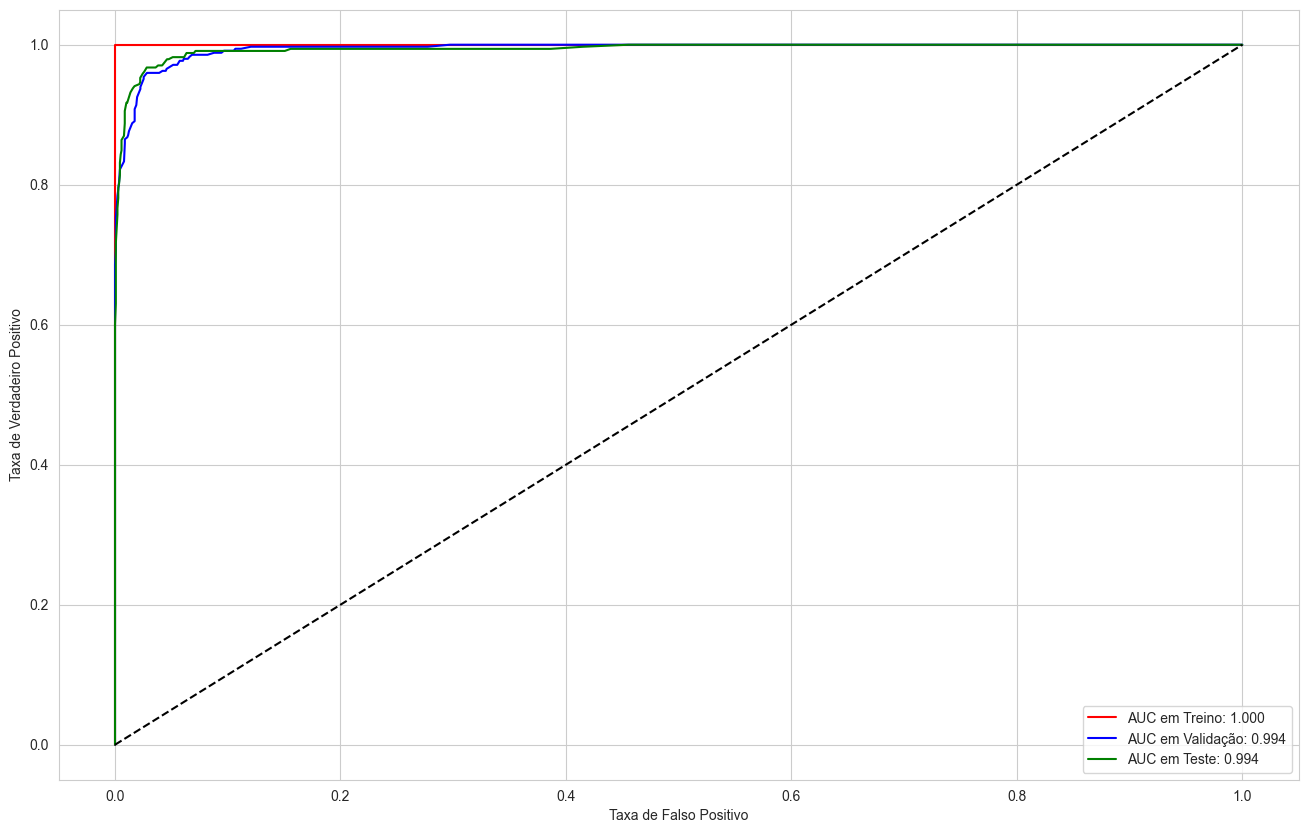

In [25]:
# Calcula a curva ROC nos dados de treino
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# Calcula a curva ROC nos dados de validação
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# Calcula a curva ROC nos dados de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

# Plot
plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-', label = 'AUC em Treino: %.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label = 'AUC em Validação: %.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label = 'AUC em Teste: %.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()

## Deploy do Modelo

In [26]:
# Carregando dados de um novo cliente
novo_cliente = pd.read_csv('data/novo_cliente.csv')
novo_cliente.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,42,53,44,31,15,12,6,4,1,-4,...,-41,-16,2,22,33,45,56,67,69,63


In [27]:
novo_cliente_scaled = scaler.transform(novo_cliente)

In [28]:
best_model.predict_proba(novo_cliente_scaled)

array([[1., 0.]])

In [29]:
best_model.predict(novo_cliente_scaled)

array([0])